# Processing API request

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import time
import datetime
import numpy as np

import matplotlib.pyplot as plt 

from eolearn.io import SentinelHubInputTask
from eolearn.core import FeatureType, OverwritePermission
from sentinelhub import CRS, BBox, DataCollection, WcsRequest, MimeType

import logging, sys
logging.basicConfig(stream=sys.stdout)
logging.getLogger("eolearn.io.processing_api").setLevel(logging.DEBUG)
logging.getLogger("sentinelhub.sentinelhub_client").setLevel(logging.DEBUG)
logging.getLogger("sentinelhub.sentinelhub_rate_limit").setLevel(logging.DEBUG)

In [2]:
size_x = 100
size_y = 100
bbox = BBox(bbox=[268892, 4624365, 268892+size_x*10, 4624365+size_y*10], crs=CRS.UTM_33N) 
# time_interval = ('2017-12-15', '2017-12-30')
# time_interval = ('2017-12-15', '2018-1-30')
time_interval = ('2015-12-15', '2018-12-15')
maxcc = 0.8
time_difference = datetime.timedelta(minutes=120)
data_collection = DataCollection.SENTINEL2_L2A
layer = {DataCollection.SENTINEL2_L1C: 'BANDS-S2-L1C', DataCollection.SENTINEL2_L2A: 'BANDS-S2-L2A'}[data_collection]

In [3]:
task = SentinelHubInputTask(
    size=(size_x, size_y),
    bands_feature=(FeatureType.DATA, 'test_feature'),
    additional_data=[(FeatureType.MASK, 'dataMask'), (FeatureType.DATA, 'SCL')],
    maxcc=maxcc,
    time_difference=time_difference,
    data_collection=data_collection,
    max_threads=3,
    cache_folder='test',
)

In [ ]:
%%time
eopatch_proc = task.execute(bbox=bbox, time_interval=time_interval)

In [5]:
proc_images = eopatch_proc[(FeatureType.DATA, 'test_feature')]
is_data = eopatch_proc[(FeatureType.MASK,'dataMask')]
#scl = eopatch_proc[(FeatureType.DATA, 'SCL')]
is_data.shape

(154, 100, 100, 1)

# Request the same images with the WcsRequest for comparison

In [6]:
wcs_images = []
for ts_id in range(len(eopatch_proc.timestamp)):
    wcs_request = WcsRequest(
        layer=layer,
        resx='10m',
        resy='10m',
        maxcc=maxcc,
        data_collection=data_collection,
        time=eopatch_proc.timestamp[ts_id],
        bbox=eopatch_proc.bbox,
        image_format=MimeType.TIFF,
        data_folder='./wcs_data/'
    )
    wcs_images.append(wcs_request.get_data(save_data=True)[0][...,:-1])
    
wcs_images = np.array(wcs_images)

In [7]:
wcs_images.shape

(154, 100, 100, 12)

# Result comparison

In [8]:
timestamp_id = 0

In [9]:
proc_image = proc_images[timestamp_id]
wcs_image = wcs_images[timestamp_id]

Difference in number of channels is because WcsRequest (and `layer`) are configured to return 

In [10]:
print('WCS shape..........:', wcs_image.shape)
print('PROCESSING shape...:', proc_image.shape)

WCS shape..........: (100, 100, 12)
PROCESSING shape...: (100, 100, 12)


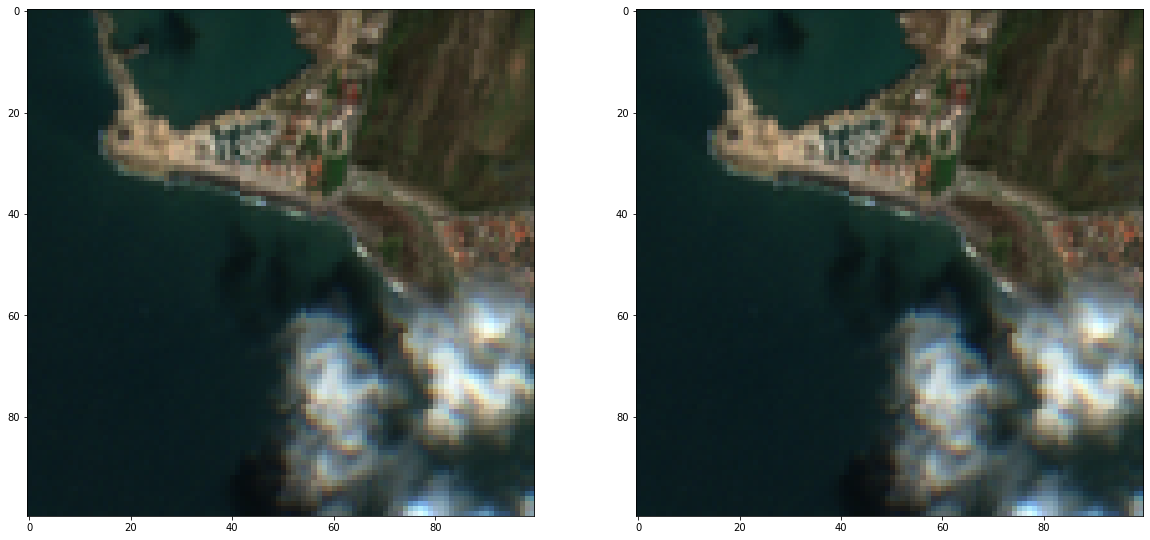

In [11]:
plt.figure(figsize=(20,20))
plt.subplot2grid((1, 2), (0, 0)).imshow(proc_image[..., [3,2,1]] * 2.5, vmin=0, vmax=1);
plt.subplot2grid((1, 2), (0, 1)).imshow(wcs_image[..., [3,2,1]] * 2.5, vmin=0, vmax=1);

In [12]:
# if we round the proc_images to 4 digits, we get exactly the same array as wcs_images,
# otherwise there are some differences
proc_image = np.round(proc_image, 4)

diffs = np.abs(proc_image - wcs_image)
whr = np.where(diffs != 0)
print('Arrays equal:', np.array_equal(proc_image, wcs_image))
print('Differing values percentage: {}%'.format((proc_image[whr].size / proc_image.size) * 100))
print('Maximum difference:', np.max(diffs))
print('Mean difference:', np.mean(diffs))

Arrays equal: True
Differing values percentage: 0.0%
Maximum difference: 0.0
Mean difference: 0.0


In [13]:
proc_image[3,5,2], wcs_image[3,5,2]

(0.0558, 0.0558)

# 16bit vs 32 bit storage

In [14]:
eopatch_proc.save('processing_patch', compress_level=9, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [15]:
import os
import math

def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)

    return convert_size(total_size)

In [ ]:
print('cache:', get_size('./wcs_data'))
print('32bit:', get_size('./processing_patch'))